# Reconnaissance des cartes

Le but est de créer un modèle capable de classifier une carte du jeu quand on la charge dans l'algorithme.

##### Notebook écrit par Théo Cramez, M1 CCM.

---

## Cadre

Dans mes hypothèses, je vais chercher à identifier et classifier une carte du jeu de cartes français (ou le jeu de 52 cartes), en reconnaissant donc leur enseigne (pic, as, carreau, trèfle) et leur "valeur" (as, 2, 3, 4, 5, 6, 7, 8, 9, 10, valet, dame, roi). On reconnaîtra aussi quelques cartes joker.
Toute carte que mes hypothèses n'arrivent pas à classifier sera également désignée comme carte "joker".

## Hypothèse n°1

- Découper le coin supérieur gauche de la carte (X de 1% à 18% de la largeur, Y de 1% à 30% de la hauteur. Ces valeurs sont choisies arbitrairement en fonction du découpage qui me semble optimal en fonction des dimensions/proportions différentes des cartes du jeu)
- Récupérer les 2 couleurs dominantes de l'image découpée pour savoir si l'une des deux est le noir ou le rouge (avec une marge d'erreur au cas où la couleur de la carte varie de celle du lot initial, si c'est une photo d'une carte par exemple).
    > Voir [ce lien](https://stackoverflow.com/a/52024748/15478987) pour voir une librairie qui pourrait me servir pour trouver les couleurs dominantes d'une image.
- Faire passer un algo d'OCR et prendre les caractères connus dans ce qu'il a sorti pour le valeur ou la lettre de la carte (ou "JOKER" (faire une recherche "approximative" car l'OCR pourrait reconnaître des caractères inexistants dans l'image, notamment à cause du fait que le découpage puisse laisser des morceaux de l'illustration de la carte sur les contours).
    > Voir [ce lien](https://www.jaided.ai/easyocr/) pour voir une librairie qui pourrait me servir pour faire de l'OCR.

Dans le code suivant, je charge puis découpe l'image de la carte.

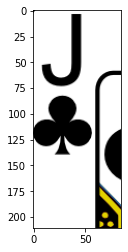

In [22]:
import os
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
%matplotlib inline
import cv2

directory = "cartes/"

carte_pleine = Image.open(directory + "jack_of_clubs2.png")

def découpage(carte):
    return carte.crop((0.01 * carte.width, 0.01 * carte.height, 0.18 * carte.width, 0.3 * carte.height))

carte = découpage(carte_pleine)

imshow(np.asarray(carte))

Essayons maintenant d'en extraire deux couleurs dominantes de l'image :

In [2]:
# fonction sympa pour afficher du texte en couleur
def colored(r, g, b, text):
    return "\033[38;2;{};{};{}m{} \033[38;2;255;255;255m".format(r, g, b, text)

def get_color(carte):
    temp_path = "cropped_card.png"
    carte.save(temp_path)
    from colorthief import ColorThief # on importe la libraire ColorThief
    color_thief = ColorThief(temp_path) # on charge l'image dans un nouvel objet
    
    # on demande d'extraire une palette de 2 couleurs dominantes, même si à cause de
    # ce qui semble être un bug de la librairie elle renvoie trois couleurs...
    couleurs = color_thief.get_palette(color_count=2, quality=10)
    
    if ((couleurs[0][0] > couleurs[0][1]) & (couleurs[0][0] > couleurs[0][2])):
        return 'r'
    return 'n'
    
print(get_color(carte))

r


Maintenant que la couleur a été reconnue, nous pouvons lancer l'algorithme de reconnaissance optique de caractères (OCR) sur la section supérieure gauche de la carte.

In [3]:
import easyocr
def recognize_characters(chemin_image):
    reader = easyocr.Reader(['en'], recog_network='english_g2', gpu=False)
    result = reader.readtext(image=directory+chemin_image, paragraph="False", detail=0)
    return result

print(recognize_characters("king_of_hearts2.png"))

Using CPU. Note: This module is much faster with a GPU.


['K']


Nous avons donc désormais la possibilité de reconnaître la couleur et la valeur d'une carte. Faisons une fonction capable d'effectuer tous les traitements à la suite pour pouvoir le faire tourner sur toutes les cartes du jeu et nous calculer un pourcentage de fiabilité de notre hypothèse.

In [4]:
def recognize_card(card_filename):
    print("traitement de " + card_filename)
    carte_pleine = Image.open(directory+card_filename)
    carte = découpage(carte_pleine)
    couleur = get_color(carte)
    valeur = recognize_characters(card_filename)
    
    #imshow(np.asarray(carte))
    
    valeurs = {
        "A": "ace",
        "2": "2",
        "3": "3",
        "4": "4",
        "5": "5",
        "6": "6",
        "7": "7",
        "8": "8",
        "9": "9",
        "10": "10",
        "J": "jack",
        "K": "king",
        "Q": "queen",
    }
    
    enseignes = {
        "n": ["clubs", "spades"],
        "r": ["diamonds", "hearts"]
    }
    
    score = 0
    
    try:
        if (valeurs[valeur[0].upper()] in card_filename) | ("joker" in card_filename):
            print("bonne valeur")
            # vu que la valeur ne représente que la moitié de la "donnée", on ne mettra que 50% de l'identification de la carte
            score+=0.5
    except:
        pass
    
    for enseigne in enseignes[couleur]:
        if enseigne in card_filename:
            #print("bonne couleur")
            # vu que la couleur donne 2 enseigne, on ne mettra que 25% de l'identification de la carte dans la couleur
            score+=0.25
    
    #print(couleur)
    #print(valeur)
    num_to_display = ""
    try:
        num_to_display = valeur[0]
    except:
        num_to_display = "NULL"
    print("couleur " + couleur + ", valeur " + num_to_display + ". score " + str(score))
    return score

directory = r'cartes/'
n = 0
total_score = 0
for filename in os.listdir(directory):
    if filename.endswith(".png"):
        n += 1
        total_score += recognize_card(filename)
    else:
        continue
print(str((total_score/n)*100)+"% de précision (score de " + str(total_score) + ", " + str(n) + " cartes testées.)")


Using CPU. Note: This module is much faster with a GPU.


traitement de 10_of_clubs.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro 10. score 0.75
traitement de 10_of_diamonds.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro 10. score 0.75
traitement de 10_of_hearts.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro 10. score 0.75
traitement de 10_of_spades.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro 10. score 0.75
traitement de 2_of_clubs.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro 2. score 0.75
traitement de 2_of_diamonds.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro 2. score 0.75
traitement de 2_of_hearts.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro 2. score 0.75
traitement de 2_of_spades.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro 2. score 0.75
traitement de 3_of_clubs.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro 3. score 0.75
traitement de 3_of_diamonds.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro 3. score 0.75
traitement de 3_of_hearts.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro 3. score 0.75
traitement de 3_of_spades.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro 3. score 0.75
traitement de 4_of_clubs.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro 4 36. score 0.25
traitement de 4_of_diamonds.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro 4. score 0.75
traitement de 4_of_hearts.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro 4. score 0.75
traitement de 4_of_spades.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro 4. score 0.75
traitement de 5_of_clubs.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro 5 Re. score 0.25
traitement de 5_of_diamonds.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro 5. score 0.75
traitement de 5_of_hearts.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro 5. score 0.75
traitement de 5_of_spades.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro 5. score 0.75
traitement de 6_of_clubs.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro 88 8c e. score 0.25
traitement de 6_of_diamonds.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro NULL. score 0.25
traitement de 6_of_hearts.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro Aa. score 0.25
traitement de 6_of_spades.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro NULL. score 0.25
traitement de 7_of_clubs.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro 6. score 0.25
traitement de 7_of_diamonds.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro NULL. score 0.25
traitement de 7_of_hearts.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro ^. score 0.25
traitement de 7_of_spades.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro NULL. score 0.25
traitement de 8_of_clubs.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro 6. score 0.25
traitement de 8_of_diamonds.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro NULL. score 0.25
traitement de 8_of_hearts.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro X 8. score 0.25
traitement de 8_of_spades.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro 8. score 0.75
traitement de 9_of_clubs.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro 0 ~. score 0.25
traitement de 9_of_diamonds.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro 9. score 0.75
traitement de 9_of_hearts.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro XX. score 0.25
traitement de 9_of_spades.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro 9. score 0.75
traitement de ace_of_clubs.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro A. score 0.75
traitement de ace_of_diamonds.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro A. score 0.75
traitement de ace_of_hearts.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro A. score 0.75
traitement de ace_of_spades.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro A. score 0.75
traitement de ace_of_spades2.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro A. score 0.75
traitement de black_joker.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro 1 38 Y 3. score 0
traitement de jack_of_clubs.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro NULL. score 0.25
traitement de jack_of_clubs2.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro :. score 0.25
traitement de jack_of_diamonds.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro NULL. score 0.25
traitement de jack_of_diamonds2.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro NULL. score 0.25
traitement de jack_of_hearts.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro NULL. score 0.25
traitement de jack_of_hearts2.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro NULL. score 0.25
traitement de jack_of_spades.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro NULL. score 0.25
traitement de jack_of_spades2.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro NULL. score 0.25
traitement de king_of_clubs.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro K. score 0.75
traitement de king_of_clubs2.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro +. score 0.25
traitement de king_of_diamonds.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro K. score 0.75
traitement de king_of_diamonds2.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro 3N 2. score 0.25
traitement de king_of_hearts.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro K. score 0.75
traitement de king_of_hearts2.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur r, numéro K. score 0.75
traitement de king_of_spades.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro K. score 0.75
traitement de king_of_spades2.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro NULL. score 0.25
traitement de queen_of_clubs.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro Q. score 0.75
traitement de queen_of_clubs2.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro NULL. score 0.25
traitement de queen_of_diamonds.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro NULL. score 0.25
traitement de queen_of_diamonds2.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro NULL. score 0.25
traitement de queen_of_hearts.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro NULL. score 0.25
traitement de queen_of_hearts2.png


Using CPU. Note: This module is much faster with a GPU.


couleur r, numéro 8. score 0.25
traitement de queen_of_spades.png


Using CPU. Note: This module is much faster with a GPU.


bon numéro
couleur n, numéro Q. score 0.75
traitement de queen_of_spades2.png


Using CPU. Note: This module is much faster with a GPU.


couleur n, numéro 1. score 0.25
traitement de red_joker.png
couleur n, numéro 8 30. score 0
48.88059701492538% de précision (score de 32.75, 67 cartes testées.)


## Hypothèse n°2

### Une autre hypothèse qui n'utilise aucun module et qui supporte les rotations (90°, 180° et 270°) ainsi que le redimensionnement de l'image :

Pour initialiser notre méthode de classification, il nous faut passer sur toutes les images du fichier des cartes pour en enregistrer les informations. Pour chaque carte :
- découper la section en haut à gauche de toutes les cartes (X de 1% à 18% de la largeur, Y de 1% à 30% de la hauteur. Ces valeurs sont choisies arbitrairement en fonction du découpage qui me semble optimal en fonction des dimensions/proportions différentes des cartes du jeu)
- passer des filtres pour rendre les images en noir et blanc (et pas en nuances de gris, attention)
- la stocker dans un dictionnaire

Enregistrement de 10_of_clubs.png
Enregistrement de 10_of_diamonds.png
Enregistrement de 10_of_hearts.png
Enregistrement de 10_of_spades.png
Enregistrement de 2_of_clubs.png
Enregistrement de 2_of_diamonds.png
Enregistrement de 2_of_hearts.png
Enregistrement de 2_of_spades.png
Enregistrement de 3_of_clubs.png
Enregistrement de 3_of_diamonds.png
Enregistrement de 3_of_hearts.png
Enregistrement de 3_of_spades.png
Enregistrement de 4_of_clubs.png
Enregistrement de 4_of_diamonds.png
Enregistrement de 4_of_hearts.png
Enregistrement de 4_of_spades.png
Enregistrement de 5_of_clubs.png
Enregistrement de 5_of_diamonds.png
Enregistrement de 5_of_hearts.png
Enregistrement de 5_of_spades.png
Enregistrement de 6_of_clubs.png
Enregistrement de 6_of_diamonds.png
Enregistrement de 6_of_hearts.png
Enregistrement de 6_of_spades.png
Enregistrement de 7_of_clubs.png
Enregistrement de 7_of_diamonds.png
Enregistrement de 7_of_hearts.png
Enregistrement de 7_of_spades.png
Enregistrement de 8_of_clubs.png
Enre

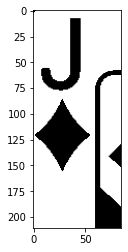

In [1]:
import os
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
%matplotlib inline

# où sont stockées les photos des cartes de référence
directory = r'cartes/'

# seuil maximal de considération des pixels comme "importants" en fonction de leur luminance
# tous les pixels plus sombres seront noirs, les autres blancs
SEUIL_LUMINANCE = 200

def découpeEtTraite(carte):
    carte = carte.crop((0.01 * carte.width, 0.01 * carte.height, 0.18 * carte.width, 0.3 * carte.height))
    carte = carte.convert("L")
    imgArr = np.asarray(carte)
    imgArr = 255.0 * (imgArr > SEUIL_LUMINANCE)
    return imgArr

# tableau des références de cartes chargées
tab_cartes_ref = dict()

# on remplit ce tableau avec toutes les cartes
def initCartesRef():
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            print('Enregistrement de ' + filename)
            carte_ref = Image.open(directory + filename)
            tab_cartes_ref[filename] = Image.fromarray(découpeEtTraite(carte_ref))
        else:
            continue
    print("Initialisation terminée ! 🎉")

initCartesRef()
test = tab_cartes_ref['jack_of_diamonds2.png']

# affichage d'un exemple de carte traitée
imshow(tab_cartes_ref['jack_of_diamonds2.png'])

Ensuite on peut commencer à travailler. On charge l'image (ou **les images**) à traiter `i`, et :
- si `i` a une taille X plus grande que sa taille Y (si elle est en format paysage), effectuer une rotation à 90° de `i` dans le sens horaire (sens choisi arbitrairement)
- on découpe la même section en haut à gauche de `i` (on pourrait aussi chopper le coin en bas à droite et le tourner à 180° pour avoir 2 images de référence à comparer...?) que l'on réécrit dans `i`
- on passe les mêmes filtres pour avoir `i` en noir et blanc
- pour chaque image `r` des infos des cartes enregistrées dans notre dossier :
    - on crée une nouvelle image `t` qui sera une copie `i`
    - on redimensionne `r` aux dimensions de `i` grâce à la fonction `resize()`
    - on soustrait les deux images pour en récupérer la différence
    - on applique le filtre pour transformer l'image en noir et blanc
    - compter le nombre de pixels blancs dans l'image et le stocker comme valeur dans un tableau à la case qui a comme identifiant de l'image `i`. À noter qu'à cette étape, si la "valeur de différence" est de zéro, on sait que nous devrions avoir trouvé exactement la bonne carte, on peut donc arrêter la boucle ici. 
- enfin, si on n'a pas trouvé de correspondance exacte, on pourra trier toutes ces valeurs par ordre croissant pour retrouver la carte qui correspond le plus à celle que l'on cherche à identifier

In [2]:
%matplotlib inline

# fonction de rotation automatique de la carte
def autoRotate(img):
    # si X > Y
    if img.size[0] > img.size[1]:
        return img.transpose(Image.ROTATE_90)
    else:
        return img

def IdentifierCarte(cheminCarte):
    # entrer le chemin de la carte à identifier, on la charge et la tourne s'il faut
    carte_à_identifier = autoRotate(Image.open(cheminCarte))
    carte_à_identifier = Image.fromarray(découpeEtTraite(carte_à_identifier))
    
    # dictionnaire pour compter les erreurs de chaque essai
    points_erreur = dict()

    # on compare avec toutes les cartes stockées pendant l'initialisation
    for carte_ref in tab_cartes_ref.items():
        carte_ref_img = carte_ref[1]
        carte_ref_img = carte_ref_img.resize(carte_à_identifier.size)

        # on crée la matrice des différences, les pixels noirs sont les corrects et les blancs les erreurs
        buffer1 = np.asarray(carte_à_identifier)
        buffer2 = np.asarray(carte_ref_img)
        substract_buffer = buffer1 - buffer2

        # on compte le nombre de pixels erronés (blancs)
        points_erreur[carte_ref[0]] = np.count_nonzero(substract_buffer == 255)
    
    # on trie les scores par ordre croissant
    points_erreur = dict(sorted(points_erreur.items(), key=lambda item: item[1]))

    return points_erreur
        
IdentifierCarte('cartes/ace_of_spades2.png')

{'ace_of_spades.png': 0,
 'ace_of_spades2.png': 0,
 'ace_of_diamonds.png': 236,
 '4_of_spades.png': 524,
 'jack_of_spades.png': 636,
 '4_of_diamonds.png': 662,
 '7_of_spades.png': 673,
 '5_of_spades.png': 777,
 '3_of_spades.png': 789,
 'jack_of_diamonds.png': 850,
 '6_of_spades.png': 871,
 '8_of_spades.png': 883,
 '2_of_spades.png': 929,
 '9_of_spades.png': 961,
 '7_of_diamonds.png': 974,
 'king_of_spades.png': 993,
 'ace_of_clubs.png': 1045,
 '3_of_diamonds.png': 1060,
 '5_of_diamonds.png': 1095,
 '8_of_diamonds.png': 1159,
 '2_of_diamonds.png': 1189,
 '6_of_diamonds.png': 1191,
 'king_of_diamonds.png': 1207,
 '4_of_clubs.png': 1287,
 '9_of_diamonds.png': 1344,
 'jack_of_clubs.png': 1451,
 '7_of_clubs.png': 1471,
 'ace_of_hearts.png': 1478,
 'queen_of_spades.png': 1556,
 '5_of_clubs.png': 1600,
 '3_of_clubs.png': 1638,
 'red_joker.png': 1646,
 'black_joker.png': 1690,
 '8_of_clubs.png': 1705,
 '6_of_clubs.png': 1719,
 'king_of_clubs.png': 1722,
 '2_of_clubs.png': 1790,
 'queen_of_diam

Pour pouvoir tester notre hypothèse et son application, je vais implémenter une petite fonction de test qui va itérer sur toutes les cartes du jeu et les tester une par une.
Je vais aussi implémenter un moyen rapide de savoir si l'identification est correcte en fonction du nom de fichier ressorti et du nom réel de la carte.

In [3]:
def compareNames(name_of_card_to_id, name_of_card_to_compare_with):
    name_of_card_to_id = name_of_card_to_id.split('.')[0]
    name_of_card_to_compare_with = name_of_card_to_compare_with.split('.')[0]
    response = (name_of_card_to_id in name_of_card_to_compare_with) | (name_of_card_to_compare_with in name_of_card_to_id)
    print("Carte à identifier => " + name_of_card_to_id + "; Carte trouvée => " + name_of_card_to_compare_with + ". " + ("✅" if response else "❌"))
    return response

n = 0
total_score = 0
for filename in os.listdir(directory):
    if filename.endswith(".png"):
        n += 1
        classification = IdentifierCarte(directory + filename)
        if compareNames(filename, list(classification.keys())[0]):
            total_score += 1
    else:
        continue
print(str((total_score/n)*100)+"% de précision (score de " + str(total_score) + ", " + str(n) + " cartes testées.)")

Carte à identifier => 10_of_clubs; Carte trouvée => 10_of_clubs. ✅
Carte à identifier => 10_of_diamonds; Carte trouvée => 10_of_diamonds. ✅
Carte à identifier => 10_of_hearts; Carte trouvée => 10_of_hearts. ✅
Carte à identifier => 10_of_spades; Carte trouvée => 10_of_spades. ✅
Carte à identifier => 2_of_clubs; Carte trouvée => 2_of_clubs. ✅
Carte à identifier => 2_of_diamonds; Carte trouvée => 2_of_diamonds. ✅
Carte à identifier => 2_of_hearts; Carte trouvée => 2_of_hearts. ✅
Carte à identifier => 2_of_spades; Carte trouvée => 2_of_spades. ✅
Carte à identifier => 3_of_clubs; Carte trouvée => 3_of_clubs. ✅
Carte à identifier => 3_of_diamonds; Carte trouvée => 3_of_diamonds. ✅
Carte à identifier => 3_of_hearts; Carte trouvée => 3_of_hearts. ✅
Carte à identifier => 3_of_spades; Carte trouvée => 3_of_spades. ✅
Carte à identifier => 4_of_clubs; Carte trouvée => 4_of_clubs. ✅
Carte à identifier => 4_of_diamonds; Carte trouvée => 4_of_diamonds. ✅
Carte à identifier => 4_of_hearts; Carte trouv

## Hypothèse 3

On reprendrait l'hypothèse 2, mais avec quelques étapes en plus pour assurer une meilleure reconnaissance au cas où les cartes varient de celles du lot de comparaison.

Lors de l'initialisation où on extrait des données de toutes les cartes du lot, on pourrait aussi découper un rectangle autour du enseigne et du valeur pour découper sur cette zone là plutôt que celle prédéfinie avec les dimensions de la carte... Peut-être à explorer plus tard...?